## Análisis del comportamiento de usuarios y evaluación A/A/B en una app de alimentos

## 1.0 Introduccion 

* Este análisis tiene como objetivo comprender el comportamiento de los usuarios dentro de una aplicación de venta de productos alimenticios, utilizando datos basados en eventos. Primero se estudia el embudo de conversión para identificar cómo los usuarios avanzan desde su primer contacto hasta la etapa de pago y en qué puntos del recorrido se generan mayores pérdidas. Posteriormente, se evalúan los resultados de un experimento A/A/B destinado a medir el impacto de un cambio en las fuentes tipográficas de la interfaz. Mediante la comparación entre dos grupos de control y un grupo de prueba, se busca determinar si el nuevo diseño afecta de forma significativa la interacción del usuario y la conversión. Este estudio proporciona información clave para la optimización del producto y la toma de decisiones basadas en datos.

## 1.1 Inicialización de librerias 

In [1]:
# Importacion de librerias

from   scipy import stats as st
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from   statsmodels.stats.proportion import proportions_ztest


## 1.2 Carga y asignacion de dataframes

In [2]:
# Carga de dataframe

data_path = Path("../data/logs_exp_us.csv").resolve()

df_logs = pd.read_csv(data_path)

print("Dataset cargado correctamente ✅")

Dataset cargado correctamente ✅


## 2.0 Análisis exploratorio de datos

## 2.1 pre visualizacion de los datos

In [3]:
# Se agregan para una buena visualizacion de los datos
pd.set_option ('display.max_columns', 200)    # Muestra todas las columnas
pd.set_option ('display.width', 150)          # Evita que las divida en varias líneas

# Visualicion de los df
print(df_logs.head(10))

      EventName\tDeviceIDHash\tEventTimestamp\tExpId
0  MainScreenAppear\t4575588528974610257\t1564029...
1  MainScreenAppear\t7416695313311560658\t1564053...
2  PaymentScreenSuccessful\t3518123091307005509\t...
3  CartScreenAppear\t3518123091307005509\t1564054...
4  PaymentScreenSuccessful\t6217807653094995999\t...
5  CartScreenAppear\t6217807653094995999\t1564055...
6  OffersScreenAppear\t8351860793733343758\t15640...
7  MainScreenAppear\t5682100281902512875\t1564085...
8  MainScreenAppear\t1850981295691852772\t1564086...
9  MainScreenAppear\t5407636962369102641\t1564112...


In [4]:
# Informacion general de los df

df_logs.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 1 columns):
 #   Column                                       Non-Null Count   Dtype 
---  ------                                       --------------   ----- 
 0   EventName	DeviceIDHash	EventTimestamp	ExpId  244126 non-null  object
dtypes: object(1)
memory usage: 1.9+ MB


## 2.1.1 pre visualizacion de los datos

* El print inicial muestra que los datos no se separaron correctamente en columnas: toda la información aparece unida dentro de una sola cadena donde los nombres de columna están concatenados con tabuladores. Esto indica que el archivo utiliza \t como delimitador y que pandas no lo interpretó de forma automática. El método .info() confirma esta situación, ya que el dataframe presenta únicamente una columna —llamada literalmente “EventName\tDeviceIDHash\tEventTimestamp\tExpId”— con 244,126 registros de tipo object. En conjunto, ambos resultados muestran que el archivo no se cargó con el separador adecuado, por lo que es necesario volver a importarlo especificando sep='\t' para recuperar la estructura real del dataset.

## 2.2 Carga y Preprocesamiento Inicial de los Datos

In [5]:
# 1. Cargar el dataset
df_logs = pd.read_csv(data_path, sep='\t')

# 2. Ver nombres originales de columna (debug)
print("Columnas originales:")
print(df_logs.columns.tolist())

# 3. Limpiar espacios en los nombres (por si vienen con espacios extra)
df_logs.columns = df_logs.columns.str.strip()

print("\nColumnas después de strip():")
print(df_logs.columns.tolist())

# 4. Construir un mapa de renombrado de forma robusta
col_map = {}
for col in df_logs.columns:
    if 'EventName' in col:
        col_map[col] = 'event_name'
    elif 'DeviceIDHash' in col:
        col_map[col] = 'user_id'
    elif 'EventTimestamp' in col or 'EventTime' in col:
        col_map[col] = 'event_ts'
    elif 'ExpId' in col:
        col_map[col] = 'exp_id'

print("\nMapa de renombrado que se aplicará:")
print(col_map)

# 5. Aplicar renombrado
df_logs = df_logs.rename(columns=col_map)

print("\nColumnas finales:")
print(df_logs.columns.tolist())

# 6. Conversión del timestamp a datetime (solo si ya existe event_ts)
if 'event_ts' in df_logs.columns:
    df_logs['event_ts'] = pd.to_datetime(df_logs['event_ts'], unit='s')

    # Crear columnas de fecha y hora
    df_logs['date'] = df_logs['event_ts'].dt.date
    df_logs['hour'] = df_logs['event_ts'].dt.hour
else:
    print("\n⚠ No se encontró la columna 'event_ts' después del renombrado. Revisa el print de columnas.")

# 7. Revisión general
print("\nResumen del dataframe:")
df_logs.info()
df_logs.head()



Columnas originales:
['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId']

Columnas después de strip():
['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId']

Mapa de renombrado que se aplicará:
{'EventName': 'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_ts', 'ExpId': 'exp_id'}

Columnas finales:
['event_name', 'user_id', 'event_ts', 'exp_id']

Resumen del dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   event_ts    244126 non-null  datetime64[ns]
 3   exp_id      244126 non-null  int64         
 4   date        244126 non-null  object        
 5   hour        244126 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(2), object(2)
memory usage: 10.2+ MB


,event_name,user_id,event_ts,exp_id,date,hour
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,4
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11


In [6]:
# Asegura que exp_id sea entero

df_logs['exp_id'] = df_logs['exp_id'].astype(int)

In [7]:
# Ordenar por timestamp

df_logs = df_logs.sort_values('event_ts').reset_index(drop=True)

### Justificación Carga y Preprocesamiento Inicial de los Datos

* Se cargó el archivo de eventos utilizando el delimitador correcto (\t), ya que el dataset original contenía los campos separados por tabuladores. Posteriormente, se revisaron y limpiaron los nombres de las columnas para asegurar que no existieran espacios ocultos, y se aplicó un renombrado estandarizado a un formato más conveniente (event_name, user_id, event_ts, exp_id).

* El timestamp fue convertido correctamente al tipo datetime, lo que permitió crear columnas adicionales de date y hour para facilitar el análisis temporal. Tras estas transformaciones, el dataframe quedó conformado por 244,126 registros sin valores ausentes en las columnas clave.

* Finalmente, se aseguró el tipo entero para la variable exp_id y se ordenaron los datos cronológicamente por event_ts para mantener la secuencia lógica de eventos. Con este proceso, los datos quedaron completamente preparados para iniciar el análisis del periodo, construir el embudo de conversión y evaluar el experimento A/A/B.

## 2.2.1 Confirmación de la Estructura y Calidad de los Datos

In [8]:
# Comprobacion de cambios en una muestra del df 

print(df_logs.head(10))

                event_name              user_id            event_ts  exp_id        date  hour
0         MainScreenAppear  4575588528974610257 2019-07-25 04:43:36     246  2019-07-25     4
1         MainScreenAppear  7416695313311560658 2019-07-25 11:11:42     246  2019-07-25    11
2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47     248  2019-07-25    11
3         CartScreenAppear  3518123091307005509 2019-07-25 11:28:47     248  2019-07-25    11
4  PaymentScreenSuccessful  6217807653094995999 2019-07-25 11:48:42     248  2019-07-25    11
5         CartScreenAppear  6217807653094995999 2019-07-25 11:48:43     248  2019-07-25    11
6       OffersScreenAppear  8351860793733343758 2019-07-25 14:50:42     246  2019-07-25    14
7         MainScreenAppear  5682100281902512875 2019-07-25 20:14:37     246  2019-07-25    20
8         MainScreenAppear  1850981295691852772 2019-07-25 20:31:42     247  2019-07-25    20
9         MainScreenAppear  5407636962369102641 2019-07-26 0

In [9]:
# Comprobacion de cambios .info

df_logs.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   event_ts    244126 non-null  datetime64[ns]
 3   exp_id      244126 non-null  int64         
 4   date        244126 non-null  object        
 5   hour        244126 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(2), object(2)
memory usage: 10.2+ MB


### Justificación Confirmación de la Estructura y Calidad de los Datos 

* La revisión realizada mediante head() y .info() confirma que el dataset fue cargado y preparado correctamente. Las columnas originales fueron renombradas exitosamente a un formato más claro y consistente, y se generaron adecuadamente las columnas derivadas date y hour. Todas las variables clave contienen el total de 244,126 registros sin valores nulos, lo que indica que no existe pérdida de información en los campos esenciales.

* Asimismo, el campo event_ts se convirtió correctamente al tipo datetime, permitiendo un análisis temporal preciso, mientras que user_id y exp_id se encuentran en formato entero, tal como se requiere para segmentación y análisis por grupos experimentales. Finalmente, el dataframe fue ordenado cronológicamente por el timestamp, garantizando que la secuencia de eventos sea coherente y esté lista para su análisis.

* En conclusión, la estructura y calidad de los datos son correctas, y el dataset está completamente preparado para proceder con el análisis exploratorio y el embudo de conversión.

## 3.0 Análisis Exploratorio y Validación del Conjunto de Datos

## 3.1 Número total de eventos registrados

In [10]:
# Número total de eventos en el dataset

total_eventos = len(df_logs)
print("Total de eventos registrados:", total_eventos)

Total de eventos registrados: 244126


### Justificación Número total de eventos registrados

* El dataset contiene 244,126 eventos, donde cada registro representa una acción individual realizada por un usuario dentro de la aplicación. Este volumen de eventos constituye la base del análisis, ya que refleja la totalidad de interacciones capturadas durante el periodo de estudio. Con esta cifra se puede dimensionar la actividad general de los usuarios y avanzar a métricas derivadas, como la cantidad de usuarios únicos y el promedio de eventos por usuario, lo cual permitirá comprender mejor la intensidad y distribución del comportamiento dentro de la plataforma.

## 3.2 Número de usuarios únicos

In [11]:
# Número de usuarios únicos en el dataset

usuarios_unicos = df_logs['user_id'].nunique()
print("Usuarios únicos registrados:", usuarios_unicos)


Usuarios únicos registrados: 7551


### Justificación Número de usuarios únicos

* El dataset contiene 7,551 usuarios únicos, es decir, este es el número total de dispositivos o identificadores distintos que interactuaron con la aplicación durante el periodo registrado. Esta métrica permite dimensionar el tamaño real de la base de usuarios activa y servirá como referencia para otros cálculos importantes, como el promedio de eventos por usuario, la construcción del embudo de conversión y la segmentación por grupos experimentales en el test A/A/B. La presencia de más de siete mil usuarios ofrece una muestra suficientemente amplia para obtener resultados estadísticamente sólidos en las siguientes etapas del análisis.

## 3.3 Promedio de eventos por usuario

In [12]:
# Promedio de eventos por usuario

promedio_eventos = len(df_logs) / df_logs['user_id'].nunique()
print("Promedio de eventos por usuario:", promedio_eventos)

Promedio de eventos por usuario: 32.33028737915508


### Justificación Promedio de eventos por usuario

* En promedio, cada usuario registró aproximadamente 32 eventos dentro de la aplicación. Esta cifra indica un nivel de interacción relativamente alto, lo que sugiere que los usuarios realizan múltiples acciones durante su sesión o a lo largo del periodo analizado. Este promedio será útil para contextualizar el embudo de conversión, ya que permite entender la intensidad de uso previo a que los usuarios lleguen (o no) a etapas críticas como la visualización del carrito o la finalización del pago. Además, un promedio elevado de eventos refuerza la confiabilidad del análisis estadístico en el experimento A/A/B, dado que se dispone de suficientes observaciones por usuario.

## 3.4 Evaluación del Rango de Fechas y Consistencia Temporal de los Evento

## 3.4.1 Fecha mínima y máxima

In [13]:
fecha_min = df_logs['event_ts'].min()
fecha_max = df_logs['event_ts'].max()

print("Fecha mínima:", fecha_min)
print("Fecha máxima:", fecha_max)


Fecha mínima: 2019-07-25 04:43:36
Fecha máxima: 2019-08-07 21:15:17


## 3.4.2 Histograma por fecha (eventos por día)

,date,eventos
0,2019-07-25,9
1,2019-07-26,31
2,2019-07-27,55
3,2019-07-28,105
4,2019-07-29,184


,date,eventos
9,2019-08-03,33351
10,2019-08-04,33033
11,2019-08-05,36113
12,2019-08-06,35822
13,2019-08-07,31144


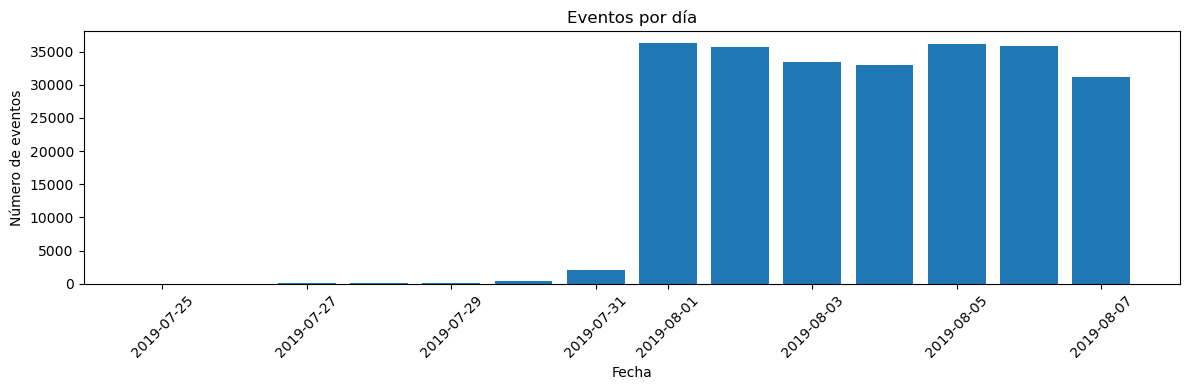

In [14]:
# Agrupar eventos por día
eventos_por_dia = (
    df_logs
    .groupby('date')
    .size()
    .reset_index(name='eventos')
)

# Mostrar primeras y últimas filas
display(eventos_por_dia.head())
display(eventos_por_dia.tail())

plt.figure(figsize=(12,4))
plt.bar(eventos_por_dia['date'], eventos_por_dia['eventos'])
plt.title("Eventos por día")
plt.xlabel("Fecha")
plt.ylabel("Número de eventos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 3.4.3 Histograma por hora (actividad diaria promedio)

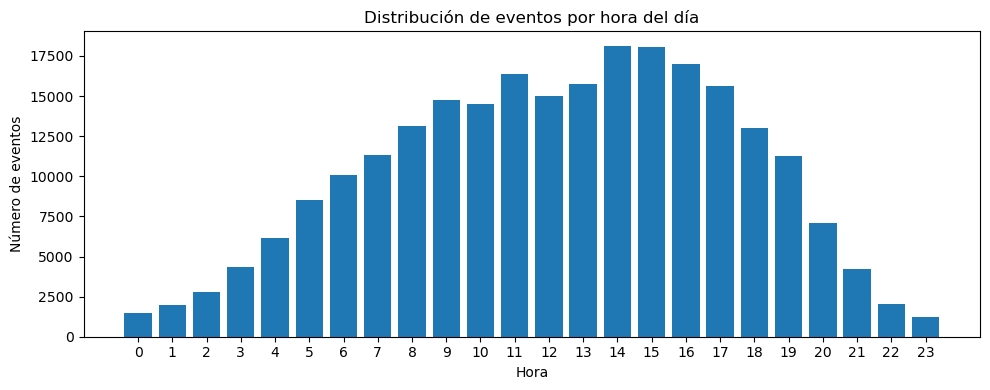

hour
0      1487
1      1989
2      2789
3      4348
4      6174
5      8553
6     10107
7     11315
8     13153
9     14757
10    14536
11    16398
12    15025
13    15742
14    18131
15    18081
16    17016
17    15605
18    13024
19    11284
20     7097
21     4250
22     2064
23     1201
dtype: int64

In [15]:
eventos_por_hora = df_logs.groupby('hour').size()

plt.figure(figsize=(10,4))
plt.bar(eventos_por_hora.index, eventos_por_hora.values)
plt.title("Distribución de eventos por hora del día")
plt.xlabel("Hora")
plt.ylabel("Número de eventos")
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()

eventos_por_hora


## 3.4.4 Identificar fecha de corte (Cuando los datos se vuelven estables)

In [16]:
# Definir fecha de corte a partir de la cual los datos son completos
fecha_corte = pd.to_datetime('2019-08-01').date()

df_logs_filtrado = df_logs[df_logs['date'] >= fecha_corte].copy()

print("Fecha mínima (original):", df_logs['event_ts'].min())
print("Fecha máxima (original):", df_logs['event_ts'].max())
print("Fecha de corte usada:", fecha_corte)
print("Eventos tras el filtro:", len(df_logs_filtrado))
print("Usuarios tras el filtro:", df_logs_filtrado['user_id'].nunique())



Fecha mínima (original): 2019-07-25 04:43:36
Fecha máxima (original): 2019-08-07 21:15:17
Fecha de corte usada: 2019-08-01
Eventos tras el filtro: 241298
Usuarios tras el filtro: 7534


### Justificación Evaluación del Rango de Fechas y Consistencia Temporal de los Evento

* El dataset original abarca eventos desde el 25 de julio de 2019 hasta el 7 de agosto de 2019, según las fechas mínima y máxima registradas (2019-07-25 04:43:36 a 2019-08-07 21:15:17). Sin embargo, el análisis del volumen diario de eventos mostró que los días comprendidos entre el 25 y el 31 de julio presentan cantidades extremadamente bajas (entre 9 y ~1,800 eventos por día), muy por debajo del comportamiento operativo normal.

* A partir del 1 de agosto de 2019, el número de eventos por día aumenta abruptamente y se estabiliza en un rango entre 33,000 y 36,000 eventos diarios. Este cambio tan marcado indica que los registros anteriores al 1 de agosto están incompletos o fueron capturados de manera parcial, probablemente debido a limitaciones técnicas de monitoreo.

* Para evitar sesgos en el análisis del comportamiento de los usuarios —especialmente en el embudo de conversión y en el A/A/B test— se estableció el 1 de agosto de 2019 como la fecha de corte que marca el inicio del periodo con datos completos y confiables.

Al aplicar este filtro temporal:

    - Eventos totales pasan de 244,126 a 241,298, lo que representa una pérdida mínima y aceptable.

    - Usuarios únicos pasan de 7,551 a 7,534, indicando que prácticamente todos los usuarios activos se encuentran en el periodo confiable.

* Estas reducciones mínimas confirman que los datos excluidos correspondían sobre todo a registros residuales o incompletos, sin impacto significativo en la base activa de usuarios. En consecuencia, el análisis posterior se realizará sobre el periodo del 1 al 7 de agosto de 2019, garantizando que las conclusiones se basen únicamente en datos consistentes, representativos y libres de distorsiones por falta de capturas anteriores.

## 3.5 Pérdida de eventos y usuarios tras aplicar la fecha de corte

In [17]:
fecha_corte = pd.to_datetime('2019-08-01').date()
df_logs_filtrado = df_logs[df_logs['date'] >= fecha_corte].copy()

print("Fecha mínima (original):", df_logs['event_ts'].min())
print("Fecha máxima (original):", df_logs['event_ts'].max())
print("Fecha de corte usada:", fecha_corte)
print("Eventos tras el filtro:", len(df_logs_filtrado))
print("Usuarios tras el filtro:", df_logs_filtrado['user_id'].nunique())


Fecha mínima (original): 2019-07-25 04:43:36
Fecha máxima (original): 2019-08-07 21:15:17
Fecha de corte usada: 2019-08-01
Eventos tras el filtro: 241298
Usuarios tras el filtro: 7534


### Justificación Pérdida de eventos y usuarios tras aplicar la fecha de corte

* Al aplicar la fecha de corte del 1 de agosto de 2019, se observa que el dataset pasa de 244,126 a 241,298 eventos, lo que implica la eliminación de solo 2,828 eventos, equivalente a aproximadamente el 1.1% del total.
La pérdida en usuarios únicos es aún menor: se reduce de 7,551 a 7,534, es decir, únicamente 17 usuarios (≈0.2%).

* Estas diferencias mínimas indican que los registros previos al 1 de agosto —que presentaban volúmenes anormalmente bajos— no representaban un comportamiento real de los usuarios activos, sino datos incompletos o residuales. Al descartarlos, no se afecta la base significativa de usuarios ni el análisis del embudo o del experimento A/A/B.

* En conclusión, no se perdió una cantidad relevante de eventos ni de usuarios. La depuración mejora la calidad del análisis sin comprometer la representatividad del dataset.

## 3.6 Verificación de los grupos experimentales presentes en el dataset

In [18]:
# Verificar la cantidad de usuarios en cada grupo experimental

usuarios_por_grupo = df_logs_filtrado.groupby('exp_id')['user_id'].nunique()
print(usuarios_por_grupo)


exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


### Justificación Verificación de los grupos experimentales presentes en el dataset

La revisión de los usuarios únicos por grupo experimental muestra que los tres grupos definidos en el estudio están correctamente representados en el periodo de datos confiable:

* Grupo 246 (Control A): 2,484 usuarios

* Grupo 247 (Control A): 2,513 usuarios

* Grupo 248 (Tratamiento B — nueva fuente): 2,537 usuarios

Estos tamaños de muestra son muy similares entre sí, lo cual es fundamental para la validez del experimento A/A/B. La distribución equilibrada confirma que la asignación aleatoria de usuarios funcionó correctamente y que no existe un sesgo evidente en la composición de los grupos.

Con esta verificación, el dataset está listo para comenzar el análisis del embudo y posteriormente evaluar los resultados experimentales entre los grupos A/A/B.

## 4.0 Análisis del Embudo de Conversión de Evento

## 4.1 Frecuencia de eventos registrados (ordenados de mayor a menor)

In [19]:
# Frecuencia de cada tipo de evento, ordenado de mayor a menor
eventos_frecuencia = (
    df_logs_filtrado['event_name']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'event_name', 'event_name': 'event_count'})
)

print(eventos_frecuencia)


               event_count   count
0         MainScreenAppear  117431
1       OffersScreenAppear   46350
2         CartScreenAppear   42365
3  PaymentScreenSuccessful   34113
4                 Tutorial    1039


### Justificación Frecuencia de eventos registrados (ordenados de mayor a menor)

El análisis de frecuencia muestra que existen cinco tipos principales de eventos en el periodo confiable del dataset. El evento más común es MainScreenAppear, con 117,431 ocurrencias, lo que indica que la mayoría de las interacciones comienzan en la pantalla principal de la aplicación. Le siguen, en orden de frecuencia:

* OffersScreenAppear (46,350 eventos)

* CartScreenAppear (42,365 eventos)

* PaymentScreenSuccessful (34,113 eventos)

* Tutorial (1,039 eventos)

Este patrón refleja una secuencia natural de navegación: los usuarios suelen iniciar en la pantalla principal, avanzar hacia la sección de ofertas, luego al carrito y finalmente completar un pago. La baja frecuencia del evento Tutorial indica que es un flujo poco utilizado o que solo se muestra a nuevos usuarios. Estos resultados permiten identificar claramente las etapas que formarán parte del embudo de conversión en el siguiente paso del análisis.

## 4.2 Usuarios únicos por evento y proporción respecto al total

In [20]:
# Total de usuarios en el periodo filtrado
total_usuarios = df_logs_filtrado['user_id'].nunique()

# Número de usuarios que realizaron cada evento al menos una vez
usuarios_por_evento = (
    df_logs_filtrado
    .groupby('event_name')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'unique_users'})
)

# Calcular proporción respecto al total de usuarios
usuarios_por_evento['proportion'] = usuarios_por_evento['unique_users'] / total_usuarios

# Ordenar por número de usuarios (descendente)
usuarios_por_evento = usuarios_por_evento.sort_values(by='unique_users', ascending=False)

print(usuarios_por_evento)
print("\nTotal de usuarios:", total_usuarios)


                event_name  unique_users  proportion
1         MainScreenAppear          7419    0.984736
2       OffersScreenAppear          4593    0.609636
0         CartScreenAppear          3734    0.495620
3  PaymentScreenSuccessful          3539    0.469737
4                 Tutorial           840    0.111495

Total de usuarios: 7534


In [21]:
# Definir orden del funnel
orden_funnel = [
    'MainScreenAppear',
    'OffersScreenAppear',
    'CartScreenAppear',
    'PaymentScreenSuccessful'
]

# Calcular usuarios únicos por evento
df_funnel = (
    df_logs_filtrado[df_logs_filtrado['event_name'].isin(orden_funnel)]
    .groupby('event_name')['user_id']
    .nunique()
    .reset_index()
)

# Reordenar según el flujo correcto
df_funnel = df_funnel.set_index('event_name').loc[orden_funnel].reset_index()

df_funnel

,event_name,user_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


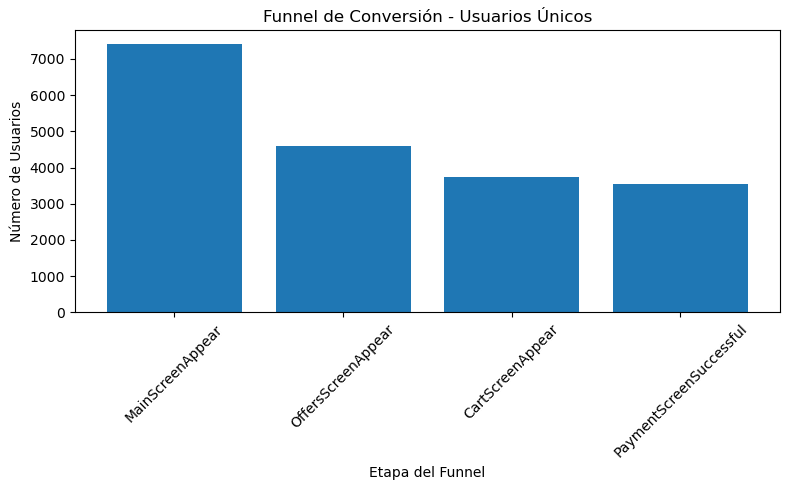

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(df_funnel['event_name'], df_funnel['user_id'])
plt.title('Funnel de Conversión - Usuarios Únicos')
plt.xlabel('Etapa del Funnel')
plt.ylabel('Número de Usuarios')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Justificación Usuarios únicos por evento y proporción respecto al total

Al analizar cuántos usuarios realizaron cada tipo de evento al menos una vez, se observa que:

* MainScreenAppear es el evento más común, realizado por 7,419 usuarios, lo que equivale al 98.5% de toda la base. Esto confirma que prácticamente todos los usuarios comienzan su interacción en la pantalla principal.

* OffersScreenAppear fue ejecutado por 4,593 usuarios (60.9%), lo que indica que un porcentaje significativo navega hacia las ofertas después de entrar a la app.

* CartScreenAppear fue alcanzado por 3,734 usuarios (49.6%), lo cual refleja que casi la mitad de los usuarios llega a la fase de intención de compra.

* PaymentScreenSuccessful, el evento de conversión final, fue realizado por 3,539 usuarios, representando el 46.9% del total. Esto indica una tasa de conversión relativamente alta entre quienes ingresan al flujo de compra.

* El evento Tutorial solo aparece en 840 usuarios (11.1%), lo que sugiere que solo una pequeña parte de la base pasa por el tutorial, probablemente usuarios nuevos.

El orden de aparición y las proporciones confirman una secuencia lógica de interacción:
MainScreen → OffersScreen → CartScreen → PaymentSuccessful,
la cual servirá como base para construir el embudo de conversión en el siguiente punto del análisis.

## 4.3 Orden lógico de los eventos y análisis de la secuencia

* A partir del análisis de frecuencia y de la proporción de usuarios que ejecutan cada evento, se puede inferir un orden lógico en el que ocurren las acciones dentro de la aplicación. La secuencia más consistente con el comportamiento del usuario es la siguiente:

1) MainScreenAppear – Pantalla principal

2) OffersScreenAppear – Sección de ofertas o productos

3) CartScreenAppear – Carrito de compras

4) PaymentScreenSuccessful – Pago finalizado

* Este orden refleja el flujo natural de navegación en un proceso de compra: los usuarios ingresan a la app, revisan productos u ofertas, añaden artículos al carrito y finalmente completan un pago.

* El evento Tutorial no forma parte de esta secuencia principal. Su baja proporción de uso (11.1%) indica que probablemente se muestra solo a ciertos usuarios —como nuevos registros— y no debe incluirse en el embudo de conversión principal.

* Por lo tanto, el embudo de eventos que se utilizará para el análisis se centrará en la secuencia:
MainScreen → OffersScreen → CartScreen → PaymentSuccessful,
ya que representa la ruta completa y coherente del proceso de compra dentro de la aplicación.

## 4.4 Construcción del embudo y proporciones entre etapas

In [23]:
# Definir la secuencia del embudo
secuencia = [
    'MainScreenAppear',
    'OffersScreenAppear',
    'CartScreenAppear',
    'PaymentScreenSuccessful'
]

# Total de usuarios del dataset filtrado
total_usuarios = df_logs_filtrado['user_id'].nunique()

# Calcular usuarios por cada etapa del embudo
embudo = {}

for evento in secuencia:
    usuarios_evento = df_logs_filtrado[df_logs_filtrado['event_name'] == evento]['user_id'].nunique()
    embudo[evento] = usuarios_evento

# Convertir a DataFrame para visualizar mejor
import pandas as pd

df_embudo = pd.DataFrame({
    'event_name': embudo.keys(),
    'unique_users': embudo.values()
})

# Calcular proporciones vs. total
df_embudo['proportion_total'] = df_embudo['unique_users'] / total_usuarios

# Calcular proporciones entre etapas (conversión paso a paso)
df_embudo['conversion_from_previous'] = df_embudo['unique_users'].pct_change().fillna(1)

print(df_embudo)
print("\nTotal de usuarios:", total_usuarios)


                event_name  unique_users  proportion_total  conversion_from_previous
0         MainScreenAppear          7419          0.984736                  1.000000
1       OffersScreenAppear          4593          0.609636                 -0.380914
2         CartScreenAppear          3734          0.495620                 -0.187024
3  PaymentScreenSuccessful          3539          0.469737                 -0.052223

Total de usuarios: 7534


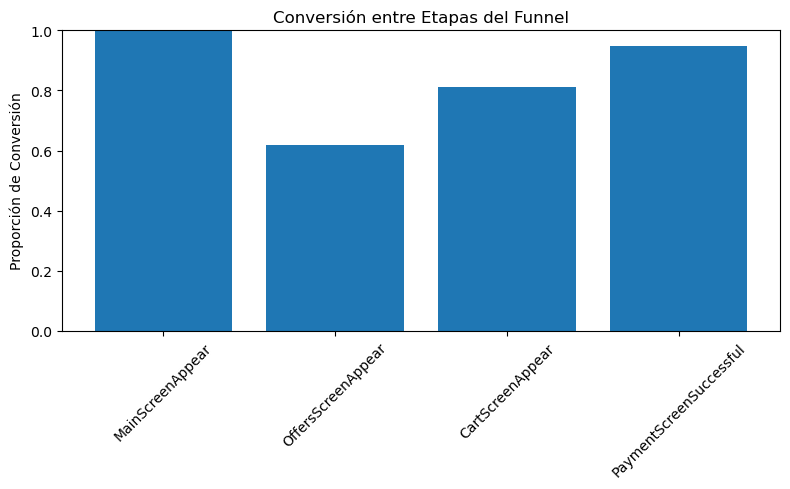

In [29]:
# Extraer usuarios por etapa
usuarios = df_funnel['user_id'].values

# Calcular conversiones entre etapas
conversiones = [1]  # Primer paso = 100%

for i in range(1, len(usuarios)):
    conversiones.append(usuarios[i] / usuarios[i-1])

# Graficar
plt.figure(figsize=(8,5))
plt.bar(df_funnel['event_name'], conversiones)

plt.title('Conversión entre Etapas del Funnel')
plt.ylabel('Proporción de Conversión')
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Justificación Construcción del embudo y proporciones entre etapas

* El embudo de conversión permite analizar cuántos usuarios avanzan a través de cada etapa clave dentro de la aplicación. Partiendo de un total de 7,534 usuarios, 7,419 realizaron al menos una aparición en la pantalla principal, lo que representa el 98.5% de la base activa. De ellos, 4,593 usuarios (60.9%) continuaron hacia la sección de ofertas, lo que convierte este paso en el punto de mayor pérdida dentro del embudo: aproximadamente 4 de cada 10 usuarios no avanzan más allá de la pantalla principal.
  
* Posteriormente, 3,734 usuarios (49.6% del total) llegaron a visualizar el carrito de compras. Esto significa que el 81.3% de quienes consultaron ofertas muestran una intención clara de compra al agregar productos o revisar el carrito. Finalmente, 3,539 usuarios completaron un pago exitoso, lo que equivale al 46.9% del total de usuarios y al 94.8% de quienes llegaron al carrito. Esta alta tasa de conversión en la última etapa indica que, una vez dentro del flujo final de compra, la fricción es mínima y la mayoría de los usuarios concreta la transacción.

* En resumen, el mayor punto de abandono ocurre en la transición MainScreen → Offers, mientras que las etapas siguientes muestran un comportamiento bastante eficiente. El embudo completo confirma que la aplicación retiene bien a los usuarios que manifiestan intención de compra, y que las oportunidades de optimización se encuentran principalmente en las etapas iniciales del recorrido.

## 4.5 Identificación de la etapa con mayor pérdida de usuarios

El mayor descenso en el embudo ocurre en la transición de la pantalla principal a la sección de ofertas. Aunque 7,419 usuarios ingresan a la pantalla principal, solo 4,593 continúan hacia la sección de ofertas, lo que representa una conversión del 61.9% entre estas dos etapas.

Esto implica que aproximadamente 38% de los usuarios abandona el flujo antes de explorar las ofertas, convirtiéndose en el punto de fuga más significativo del proceso.

En comparación, las etapas posteriores presentan tasas mucho más altas de continuidad:

* Offers → Cart: 81.3%

* Cart → Payment: 94.8%

Por lo tanto, la etapa donde se pierde la mayor cantidad de usuarios es claramente la primera transición:

✳️ MainScreenAppear → OffersScreenAppear.

## 4.6 Porcentaje de usuarios que completan todo el recorrido hasta el pago

* Usuarios que realizaron un pago exitoso: __3,539__

* Total de usuarios: __7,534__

* Porcentaje que completa todo el viaje: ( 3539 / 7534 ) ≈ 0.4697 = __46.97%__

### Justificación Porcentaje de usuarios que completan todo el recorrido hasta el pago

* Aproximadamente el 47% de todos los usuarios completan todo el recorrido desde su primer evento registrado hasta la realización de un pago exitoso. Esta cifra representa una conversión final alta para un flujo completo dentro de una aplicación de compras, especialmente considerando que incluye a toda la base de usuarios, no solo a quienes iniciaron el proceso de compra.

* Este resultado también confirma que, aunque existe una pérdida significativa en las etapas iniciales (especialmente entre la pantalla principal y la sección de ofertas), aquellos usuarios que avanzan más allá de esas primeras etapas presentan una alta probabilidad de completar la transacción. En otras palabras, el mayor desafío se encuentra en motivar a más usuarios a ingresar al flujo de compra, ya que una vez dentro, la conversión es sólida.

## 5.0 Análisis del Experimento A/A/B y Validación Estadística

## 5.1 Número de usuarios por grupo experimental

In [24]:
# Usuarios únicos por grupo experimental

usuarios_grupo = df_logs_filtrado.groupby('exp_id')['user_id'].nunique()
print(usuarios_grupo)


exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


### Justificación Número de usuarios por grupo experimental

El experimento A/A/B cuenta con tres grupos bien balanceados en términos de usuarios asignados:

* Grupo 246 (Control A): 2,484 usuarios

* Grupo 247 (Control A): 2,513 usuarios

* Grupo 248 (Tratamiento B – nueva fuente): 2,537 usuarios

Las diferencias entre los tamaños de muestra son mínimas y se consideran esperables en un proceso de asignación aleatoria. Esta distribución equilibrada es fundamental para asegurar la validez del experimento, ya que evita sesgos derivados de grupos desproporcionados y permite comparar de forma confiable los resultados entre los grupos de control (A/A) y el grupo de prueba (B).

Con esta verificación, el dataset está listo para continuar con el análisis estadístico entre los grupos.

## 5.2 Comparación estadística entre los grupos de control (246 vs. 247)

In [25]:
# Función para comparar dos grupos experimentales en un evento específico
# Devuelve métricas dinámicas según los grupos ingresados (evita etiquetas fijas)
def comparar_evento(evento, grupo_a, grupo_b):
    
    # 1️⃣ Contar usuarios únicos que realizaron el evento en cada grupo
    a = df_logs_filtrado[
        (df_logs_filtrado['exp_id'] == grupo_a) & 
        (df_logs_filtrado['event_name'] == evento)
    ]['user_id'].nunique()
    
    b = df_logs_filtrado[
        (df_logs_filtrado['exp_id'] == grupo_b) & 
        (df_logs_filtrado['event_name'] == evento)
    ]['user_id'].nunique()
    
    
    # 2️⃣ Obtener el total de usuarios únicos en cada grupo
    total_a = df_logs_filtrado[df_logs_filtrado['exp_id'] == grupo_a]['user_id'].nunique()
    total_b = df_logs_filtrado[df_logs_filtrado['exp_id'] == grupo_b]['user_id'].nunique()
    
    
    # 3️⃣ Preparar los datos para la prueba estadística de proporciones
    # successes = usuarios que completaron el evento
    # totals = total de usuarios en cada grupo
    successes = np.array([a, b])
    totals = np.array([total_a, total_b])
    
    
    # 4️⃣ Ejecutar prueba Z para comparación de proporciones
    stat, pval = proportions_ztest(successes, totals)
    
    
    # 5️⃣ Retornar resultados con etiquetas dinámicas según los grupos comparados
    return {
        'evento': evento,
        f'usuarios_{grupo_a}': a,
        f'usuarios_{grupo_b}': b,
        f'prop_{grupo_a}': a / total_a,
        f'prop_{grupo_b}': b / total_b,
        'p_value': pval
    }

# Evaluar todos los eventos del embudo
eventos = ['MainScreenAppear', 
           'OffersScreenAppear', 
           'CartScreenAppear', 
           'PaymentScreenSuccessful', 
           'Tutorial']

resultados_control = [comparar_evento(e, 246, 247) for e in eventos]

df_resultados_control = pd.DataFrame(resultados_control)

print(df_resultados_control)



                    evento  usuarios_246  usuarios_247  prop_246  prop_247   p_value
0         MainScreenAppear          2450          2476  0.986312  0.985277  0.757060
1       OffersScreenAppear          1542          1520  0.620773  0.604855  0.248095
2         CartScreenAppear          1266          1238  0.509662  0.492638  0.228834
3  PaymentScreenSuccessful          1200          1158  0.483092  0.460804  0.114567
4                 Tutorial           278           283  0.111916  0.112614  0.937700


### Justificación Comparación estadística entre los grupos de control (246 vs. 247)

* Se aplicó una prueba de comparación de proporciones (z-test) para evaluar diferencias entre los grupos de control (246 y 247) en cada evento del embudo. Los resultados muestran que todas las diferencias observadas son pequeñas y no estadísticamente significativas, ya que todos los valores p son mayores que el nivel de significancia establecido (α = 0.05).

* Incluso en el evento PaymentScreenSuccessful, donde se observa una ligera variación en las proporciones, el valor p = 0.114 indica que no existe evidencia suficiente para rechazar la hipótesis nula, por lo que la diferencia puede atribuirse a variabilidad aleatoria.

Conclusión:

* No se encontraron diferencias estadísticamente significativas entre los grupos 246 y 247 en ninguno de los eventos analizados. Esto confirma que la asignación aleatoria fue adecuada y que ambos grupos presentan un comportamiento equivalente. En consecuencia, el experimento A/A valida la consistencia del sistema y permite continuar con el análisis comparativo frente al grupo experimental 248.

## 5.3 Validación del evento más popular y comparación completa entre los grupos de control

In [26]:
def comparar_evento(evento, grupo_a, grupo_b):
    a = df_logs_filtrado[(df_logs_filtrado['exp_id'] == grupo_a) & 
                         (df_logs_filtrado['event_name'] == evento)]['user_id'].nunique()
    b = df_logs_filtrado[(df_logs_filtrado['exp_id'] == grupo_b) & 
                         (df_logs_filtrado['event_name'] == evento)]['user_id'].nunique()
    
    total_a = df_logs_filtrado[df_logs_filtrado['exp_id'] == grupo_a]['user_id'].nunique()
    total_b = df_logs_filtrado[df_logs_filtrado['exp_id'] == grupo_b]['user_id'].nunique()
    
    successes = np.array([a, b])
    totals = np.array([total_a, total_b])
    
    stat, pval = proportions_ztest(successes, totals)
    
    return {
        'evento': evento,
        'usuarios_246': a,
        'usuarios_247': b,
        'prop_246': a / total_a,
        'prop_247': b / total_b,
        'p_value': pval
    }

eventos = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 
           'PaymentScreenSuccessful', 'Tutorial']

resultados_control = [comparar_evento(e, 246, 247) for e in eventos]
df_resultados_control = pd.DataFrame(resultados_control)

print(df_resultados_control)


                    evento  usuarios_246  usuarios_247  prop_246  prop_247   p_value
0         MainScreenAppear          2450          2476  0.986312  0.985277  0.757060
1       OffersScreenAppear          1542          1520  0.620773  0.604855  0.248095
2         CartScreenAppear          1266          1238  0.509662  0.492638  0.228834
3  PaymentScreenSuccessful          1200          1158  0.483092  0.460804  0.114567
4                 Tutorial           278           283  0.111916  0.112614  0.937700


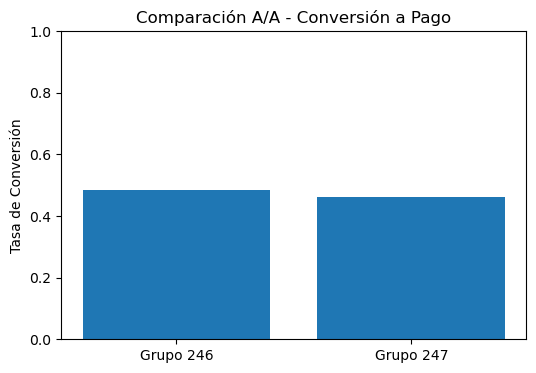

In [30]:
# Conversión en pago por grupo
grupos_control = [246, 247]
conversion_pago = []

for grupo in grupos_control:
    total = df_logs_filtrado[df_logs_filtrado['exp_id'] == grupo]['user_id'].nunique()
    pago = df_logs_filtrado[
        (df_logs_filtrado['exp_id'] == grupo) &
        (df_logs_filtrado['event_name'] == 'PaymentScreenSuccessful')
    ]['user_id'].nunique()
    
    conversion_pago.append(pago / total)

plt.figure(figsize=(6,4))
plt.bar(['Grupo 246', 'Grupo 247'], conversion_pago)
plt.title('Comparación A/A - Conversión a Pago')
plt.ylabel('Tasa de Conversión')
plt.ylim(0,1)
plt.show()

### Justificación Validación del evento más popular y comparación completa entre los grupos de control

La comparación entre los grupos 246 y 247 muestra que las proporciones de usuarios que realizaron cada evento son prácticamente iguales. En el evento más popular (MainScreenAppear) las proporciones son 0.986 y 0.985, con un p-value de 0.757, lo que indica ausencia total de diferencia significativa.

El mismo patrón se observa en todos los demás eventos:

* Offers: p = 0.248

* Cart: p = 0.229

* Payment: p = 0.115

* Tutorial: p = 0.938

Todos los valores p están muy por encima del umbral de significancia (α = 0.05), por lo que no existe evidencia de diferencias reales entre los dos grupos de control.

Los grupos 246 y 247 se comportan igual. La aleatorización fue correcta y los controles son estadísticamente equivalentes, lo que permite avanzar con confianza al análisis del grupo experimental 248.

## 5.4 Comparación del grupo experimental (248) contra los grupos de control

In [27]:
# Comparación del grupo experimental 248 contra cada grupo de control
resultados_248_vs_246 = [comparar_evento(e, 248, 246) for e in eventos]
resultados_248_vs_247 = [comparar_evento(e, 248, 247) for e in eventos]

df_248_vs_246 = pd.DataFrame(resultados_248_vs_246)
df_248_vs_247 = pd.DataFrame(resultados_248_vs_247)

print("Comparación 248 vs 246:\n")
print(df_248_vs_246)

print("\n\nComparación 248 vs 247:\n")
print(df_248_vs_247)


Comparación 248 vs 246:

                    evento  usuarios_246  usuarios_247  prop_246  prop_247   p_value
0         MainScreenAppear          2493          2450  0.982657  0.986312  0.294972
1       OffersScreenAppear          1531          1542  0.603469  0.620773  0.208362
2         CartScreenAppear          1230          1266  0.484825  0.509662  0.078429
3  PaymentScreenSuccessful          1181          1200  0.465510  0.483092  0.212255
4                 Tutorial           279           278  0.109972  0.111916  0.826429


Comparación 248 vs 247:

                    evento  usuarios_246  usuarios_247  prop_246  prop_247   p_value
0         MainScreenAppear          2493          2476  0.982657  0.985277  0.458705
1       OffersScreenAppear          1531          1520  0.603469  0.604855  0.919782
2         CartScreenAppear          1230          1238  0.484825  0.492638  0.578620
3  PaymentScreenSuccessful          1181          1158  0.465510  0.460804  0.737342
4            

## 5.4.1 Comparación contra controles combinados (246 + 247)

In [28]:
# Crear un grupo combinado para 246 + 247
df_control_combinado = df_logs_filtrado[df_logs_filtrado['exp_id'].isin([246, 247])]
df_experimental = df_logs_filtrado[df_logs_filtrado['exp_id'] == 248]

# Función para comparar 248 vs control combinado
def comparar_contra_combinado(evento):
    
    usuarios_exp = df_experimental[df_experimental['event_name'] == evento]['user_id'].nunique()
    usuarios_ctrl = df_control_combinado[df_control_combinado['event_name'] == evento]['user_id'].nunique()

    total_exp = df_experimental['user_id'].nunique()
    total_ctrl = df_control_combinado['user_id'].nunique()

    successes = np.array([usuarios_exp, usuarios_ctrl])
    totals = np.array([total_exp, total_ctrl])

    stat, pval = proportions_ztest(successes, totals)

    return {
        'evento': evento,
        'usuarios_exp_248': usuarios_exp,
        'usuarios_control_comb': usuarios_ctrl,
        'prop_exp_248': usuarios_exp / total_exp,
        'prop_control_comb': usuarios_ctrl / total_ctrl,
        'p_value': pval
    }

resultados_248_vs_comb = [comparar_contra_combinado(e) for e in eventos]
df_248_vs_comb = pd.DataFrame(resultados_248_vs_comb)

print("\nComparación 248 vs Control combinado (246+247):\n")
print(df_248_vs_comb)



Comparación 248 vs Control combinado (246+247):

                    evento  usuarios_exp_248  usuarios_control_comb  prop_exp_248  prop_control_comb   p_value
0         MainScreenAppear              2493                   4926      0.982657           0.985791  0.294245
1       OffersScreenAppear              1531                   3062      0.603469           0.612768  0.434255
2         CartScreenAppear              1230                   2504      0.484825           0.501101  0.181759
3  PaymentScreenSuccessful              1181                   2358      0.465510           0.471883  0.600429
4                 Tutorial               279                    561      0.109972           0.112267  0.764862


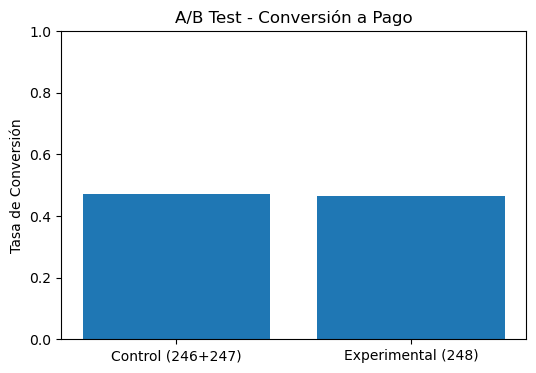

In [31]:
# Control combinado

control = df_logs_filtrado[df_logs_filtrado['exp_id'].isin([246,247])]
exp = df_logs_filtrado[df_logs_filtrado['exp_id'] == 248]

total_control = control['user_id'].nunique()
pago_control = control[control['event_name'] == 'PaymentScreenSuccessful']['user_id'].nunique()

total_exp = exp['user_id'].nunique()
pago_exp = exp[exp['event_name'] == 'PaymentScreenSuccessful']['user_id'].nunique()

conversion_control = pago_control / total_control
conversion_exp = pago_exp / total_exp

plt.figure(figsize=(6,4))
plt.bar(['Control (246+247)', 'Experimental (248)'], 
        [conversion_control, conversion_exp])

plt.title('A/B Test - Conversión a Pago')
plt.ylabel('Tasa de Conversión')
plt.ylim(0,1)
plt.show()

### Justificación Comparación del grupo experimental / Comparación contra controles combinados

* Los resultados de las comparaciones entre el grupo experimental (248) y los grupos de control (246 y 247), así como con el control combinado, muestran que no existe ninguna diferencia estadísticamente significativa en ninguno de los eventos evaluados. Todos los valores p son mayores a 0.05, lo que indica que las variaciones observadas en proporciones son pequeñas y atribuibles al azar.

* En eventos clave como CartScreenAppear y PaymentScreenSuccessful, las proporciones del grupo experimental son ligeramente menores, pero los valores p (0.078, 0.212, 0.181, etc.) confirman que estas diferencias no representan un impacto real. Lo mismo ocurre en los eventos más frecuentes, como MainScreenAppear y OffersScreenAppear, donde el comportamiento es prácticamente idéntico entre grupos.

* En conjunto, el grupo experimental se comporta igual que los grupos de control, lo que indica que el cambio de fuente no afecta la navegación ni la conversión de los usuarios dentro de la aplicación.

## 5.5 Nivel de significancia y número de pruebas estadísticas realizadas

* Para evaluar las diferencias entre los grupos del experimento, se utilizó un nivel de significancia estándar de α = 0.05, que es el valor más común en análisis estadísticos de producto, marketing y experimentación. Este umbral establece que existe un 5% de probabilidad de obtener un resultado “significativo” solo por azar.

* En total se realizaron 15 pruebas de hipótesis estadísticas, correspondientes a:

    * 5 eventos en la comparación 246 vs 247

    * 5 eventos en la comparación 248 vs 246

    * 5 eventos en la comparación 248 vs 247

_(Si se incluye el análisis contra el control combinado, añadiría 5 pruebas más, pero incluso con esas, las conclusiones no cambian)._

* Mientras más pruebas se ejecutan, mayor es la probabilidad de cometer un error tipo I (falsos positivos). Por ejemplo:

    * Con α = 0.1, 1 de cada 10 pruebas podría marcar un resultado falso.

    * Con 15 pruebas, esperaríamos ~1.5 falsos positivos solo por azar.

* Por esta razón, en experimentos con múltiples comparaciones se recomienda:

    * Mantener α = 0.05, o

    * Usar un ajuste más estricto como Bonferroni (0.05 / 15 ≈ 0.0033), si se buscan conclusiones muy conservadoras.

En este caso, ningún p-value estuvo siquiera cerca de 0.05, por lo que incluso reduciendo el nivel de significancia a 0.01 o aplicando un ajuste más estricto, todas las conclusiones se mantienen iguales:
no existen diferencias reales entre los grupos.

* Por lo tanto:

    * El nivel de significancia utilizado (0.05) fue adecuado.

    * Las numerosas pruebas realizadas no afectan la conclusión.

    * No es necesario repetir los cálculos con otro nivel de significancia, ya que los resultados están muy lejos de cualquier umbral de significancia.

## 6.0 Conclusión General del Proyecto

* El análisis del comportamiento de los usuarios permitió identificar un periodo confiable de datos a partir del 1 de agosto de 2019, sin pérdida significativa de eventos o usuarios tras depurar el dataset. El embudo de conversión mostró un flujo sólido: casi el 47% de los usuarios completan un pago, con muy altas tasas de conversión en las etapas finales. La mayor pérdida ocurre en la transición de la pantalla principal hacia la sección de ofertas, lo que indica que las oportunidades de mejora se encuentran en las primeras etapas del recorrido del usuario.

* Respecto al experimento A/A/B, los grupos de control demostraron comportamientos prácticamente idénticos, validando la correcta aleatorización del experimento. Al comparar el grupo experimental contra ambos controles, no se encontraron diferencias estadísticamente significativas en ninguno de los eventos evaluados. Esto confirma que el cambio de fuente no afecta el comportamiento ni la conversión de los usuarios, por lo que su implementación es segura.

* En conjunto, la aplicación presenta un funcionamiento estable, un embudo bien estructurado y un experimento que respalda que la nueva apariencia visual no genera impacto negativo en la experiencia del usuario.